In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer, util
# import torch
# import mplcursors
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import json
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
import tiktoken
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter


import textwrap
from time import monotonic

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', '00', 'no2', 'no3'])

In [2]:
df = pd.read_csv('../data/combined_df_pubdate.csv')
df.sample(3)

,email,first_name,last_name,faculty,department,area_of_focus,gs_link,author_id,title,abstract,...,gs_url,embeddings,umap_x,umap_y,cluster,kde,top_keywords,department_broad,focus_label,focus_tag
1672,vganesh@uwaterloo.ca,Vijay,Genesh,Engineering,Electrical and Computer Engineering,"AT/SMT solvers and higher-order provers, Softw...",https://scholar.google.com/citations?user=YP23...,YP23eR0AAAAJ,Learning Modulo Theories,Modeling problems containing a mixture of Bool...,...,https://scholar.google.com/citations?view_op=v...,"[-0.045483559370040894, -0.05487724021077156, ...",6.209096,1.391453,1,-5.469094,"Spacecraft issues, anomaly detection, multivar...",Engineering and Technology,4,"engineering,, software, interaction,"
1245,peng.hu@uwaterloo.ca,Peng,Hu,Mathematics,Cheriton School of Computer Science,"AI/ML, Data Communications and Networking",https://scholar.google.ca/citations?user=4rUa3...,4rUa3UIAAAAJ,An Anomaly Detection Method for Satellites Usi...,"Recently, there has been a significant amount ...",...,https://scholar.google.com/citations?view_op=v...,"[-0.1308351755142212, -0.08675556629896164, 0....",5.365187,6.342324,1,-4.734256,"Spacecraft issues, anomaly detection, multivar...",Engineering and Technology,2,"computer, vision,, ai"
258,liping.fu@uwaterloo.ca,Liping,Fu,Engineering,Civil and Environmental Engineering,transportation,https://scholar.google.ca/citations?user=FKpsU...,FKpsUMgAAAAJ,An empirical investigation of driver car-follo...,This study aims to address the questions of ho...,...,https://scholar.google.com/citations?view_op=v...,"[0.05969052389264107, -0.08932336419820786, 0....",7.647873,2.230366,9,-6.447394,"Precision medicine, dynamic treatment regimes,...",Environmental Studies,7,"computational, analysis,, health"


In [3]:
df.columns

Index(['email', 'first_name', 'last_name', 'faculty', 'department',
       'area_of_focus', 'gs_link', 'author_id', 'title', 'abstract', 'doi',
       'gs_url', 'embeddings', 'umap_x', 'umap_y', 'cluster', 'kde',
       'top_keywords', 'department_broad', 'focus_label', 'focus_tag'],
      dtype='object')

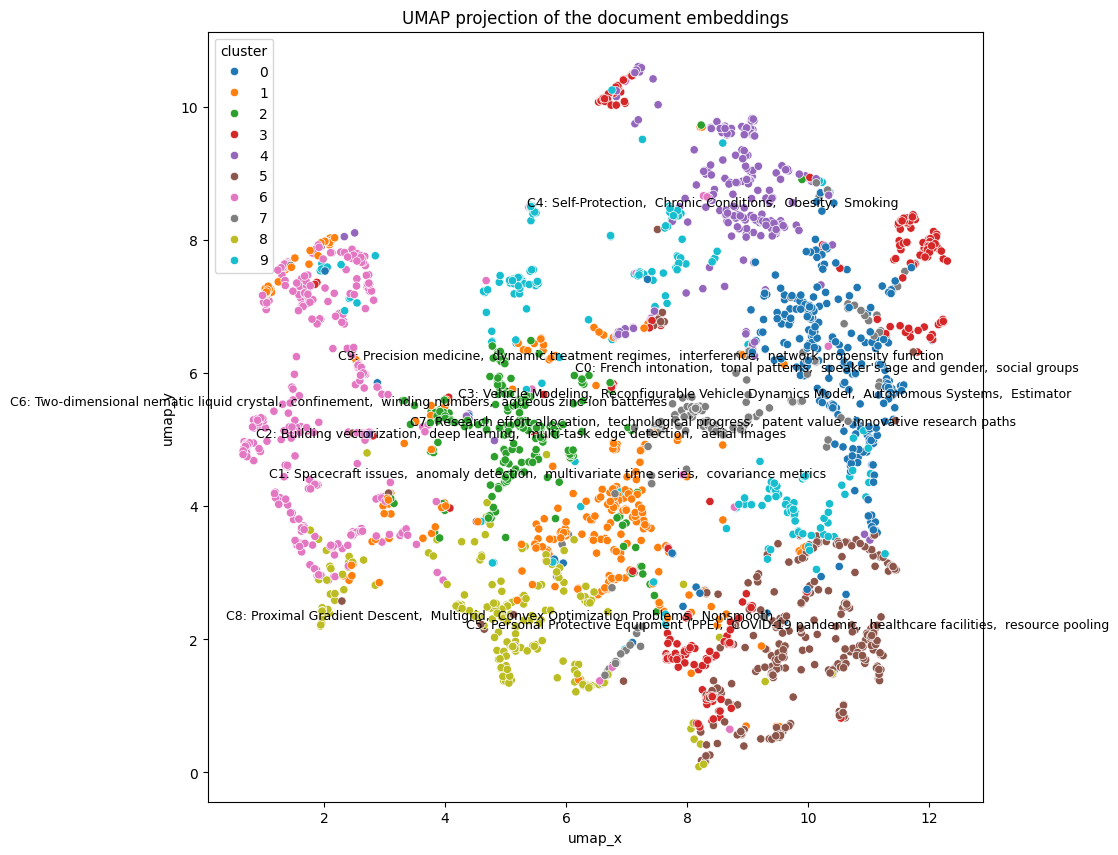

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='umap_x', y='umap_y', hue='cluster', data=df, palette='tab10', ax=ax)

# contourf
# KernelDensity
# x = df['embeddings'].apply(lambda x: x[0]).values
# y = df['embeddings'].apply(lambda x: x[1]).values
# xx, yy = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = KernelDensity(bandwidth=0.5, metric='euclidean', kernel='gaussian')
# kernel.fit(values.T)
# f = np.reshape(np.exp(kernel.score_samples(positions.T)), xx.shape)

# ax.contourf(xx, yy, f, cmap='Blues', alpha=0.3)
ax.set_title('UMAP projection of the document embeddings')


# legend showing top_keywords
for cluster in range(10):
    keywords = df[df['cluster'] == cluster]['top_keywords'].values[0]
    keywords = keywords.split(',')[:4]
    if len(keywords) > 0:
        # based on umap_x, y's mean position
        x_mean = df[df['cluster'] == cluster]['umap_x'].mean()
        y_mean = df[df['cluster'] == cluster]['umap_y'].mean()
        
        ax.text(x_mean, y_mean, f'C{cluster}: {", ".join(keywords)}', fontsize=9, color='black', ha='center')

plt.show()

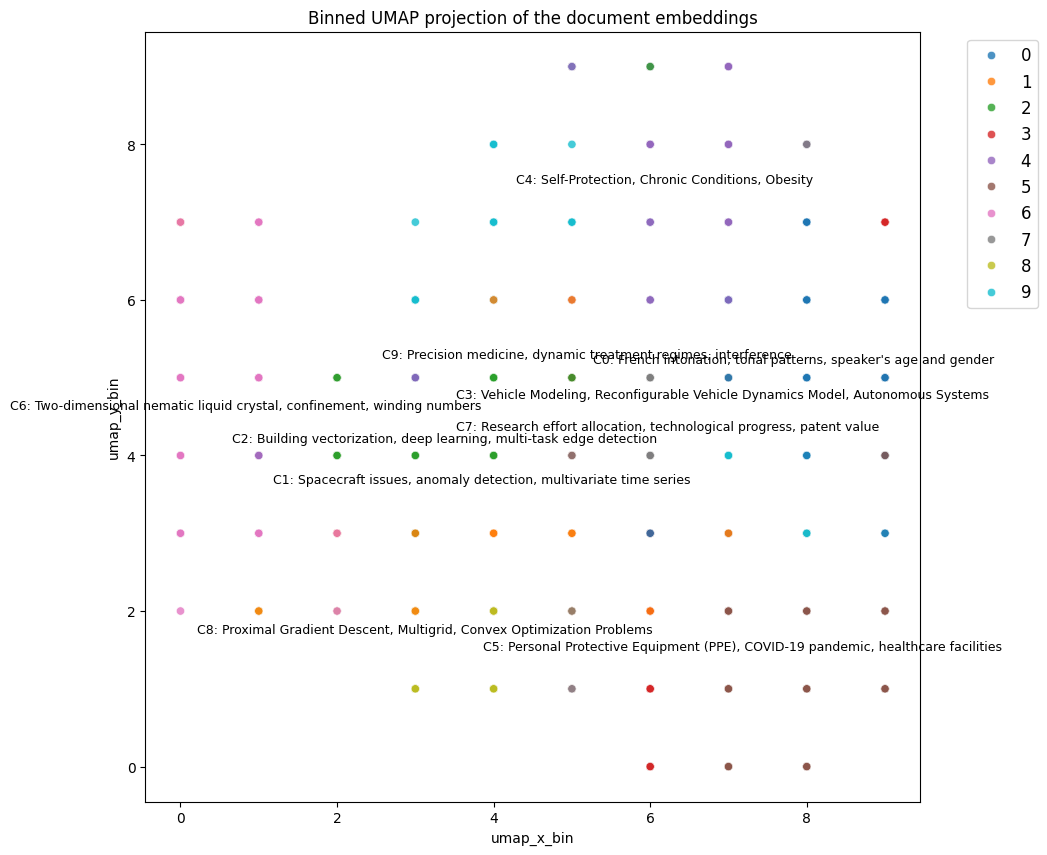

In [16]:
# Binning data
BINS_NUM = 10

# a range from 10 to 20 with 2 steps
for bin in range(10, 40, 2):
    df[f'umap_x_bin_{bin}'] = pd.cut(df['umap_x'], bins=bin, labels=False)
    df[f'umap_y_bin_{bin}'] = pd.cut(df['umap_y'], bins=bin, labels=False)

df['umap_x_bin'] = pd.cut(df['umap_x'], bins=BINS_NUM, labels=False)
df['umap_y_bin'] = pd.cut(df['umap_y'], bins=BINS_NUM, labels=False)
df['bin_id'] = df.apply(lambda x: f'{x["umap_x_bin"]}_{x["umap_y_bin"]}', axis=1)

plt.figure(figsize=(10, 10))

# plot binning data, larger dots represent more messages in the bin
sns.scatterplot(x='umap_x_bin', y='umap_y_bin', data=df, sizes=(20, 200), legend=True, alpha=0.8, hue='cluster', palette='tab10')


for cluster in range(10):
    keywords = df[df['cluster'] == cluster]['top_keywords'].values[0]
    keywords = keywords.split(',')[:3]
    if len(keywords) > 0:
        # based on umap_x, y's mean position
        x_mean = df[df['cluster'] == cluster]['umap_x_bin'].mean()
        y_mean = df[df['cluster'] == cluster]['umap_y_bin'].mean()
        
        plt.text(x_mean, y_mean, f'C{cluster}: {",".join(keywords)}', fontsize=9, color='black', ha='center')

    
    
plt.title('Binned UMAP projection of the document embeddings')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

plt.show()

In [17]:
df.to_csv('../data/ai_pubdate.csv', index=False)

In [18]:
df.columns

Index(['email', 'first_name', 'last_name', 'faculty', 'department',
       'area_of_focus', 'gs_link', 'author_id', 'title', 'abstract', 'doi',
       'gs_url', 'embeddings', 'umap_x', 'umap_y', 'cluster', 'kde',
       'top_keywords', 'department_broad', 'focus_label', 'focus_tag',
       'umap_x_bin_10', 'umap_y_bin_10', 'umap_x_bin_12', 'umap_y_bin_12',
       'umap_x_bin_14', 'umap_y_bin_14', 'umap_x_bin_16', 'umap_y_bin_16',
       'umap_x_bin_18', 'umap_y_bin_18', 'umap_x_bin', 'umap_y_bin',
       'umap_x_bin_20', 'umap_y_bin_20', 'umap_x_bin_22', 'umap_y_bin_22',
       'umap_x_bin_24', 'umap_y_bin_24', 'umap_x_bin_26', 'umap_y_bin_26',
       'umap_x_bin_28', 'umap_y_bin_28', 'umap_x_bin_30', 'umap_y_bin_30',
       'umap_x_bin_32', 'umap_y_bin_32', 'umap_x_bin_34', 'umap_y_bin_34',
       'umap_x_bin_36', 'umap_y_bin_36', 'umap_x_bin_38', 'umap_y_bin_38',
       'bin_id'],
      dtype='object')